In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from peewee import *
from sophius.db import *
import pandas as pd
import seaborn as sns

query = (Runs
         .select(Runs.val_acc, Runs.train_acc, Models)
         .where(Runs.exp_id==1)
         .join(Models)
         .dicts())
df = pd.DataFrame(query)
df

,val_acc,train_acc,id,hash,flops,macs,params
0,0.663141,0.865986,1,0080810a080800000049200001000000,2053728,1009440,145642
1,0.399900,0.405278,2,00880406200000000024a80001000000,30624,14544,954
2,0.642238,0.700962,3,0080804520000000400000000023300001000000,1437216,706848,29770
3,0.479167,0.488632,4,0080421210080000400000000010000001000000,3738752,1776896,7818
4,0.436639,0.439653,5,008402112000000000485000400000000010000001000000,357920,172960,986
...,...,...,...,...,...,...,...
9573,0.732192,0.834605,9470,0080412220000000004310000022d00001000000,20737664,10118400,297738
9574,0.731560,0.804677,9111,00802122200000000042a0000024b00001000000,30382272,14868480,137482
9575,0.723277,0.816897,9471,00802422080400000044a0000025500001000000,12238848,5799936,496907
9576,0.713692,0.765956,9472,0080412110020000004260000023500001000000,15676416,7681280,164618


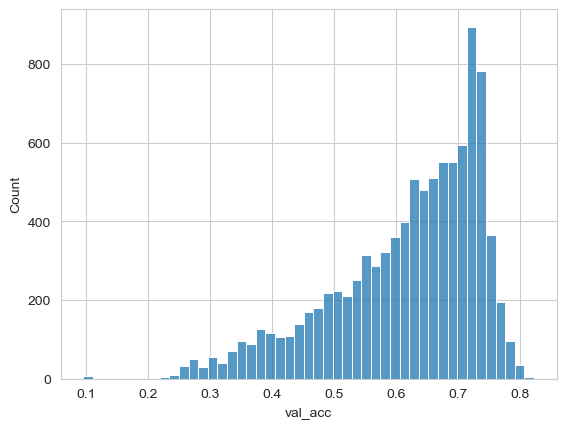

In [6]:
sns.histplot(df.val_acc);

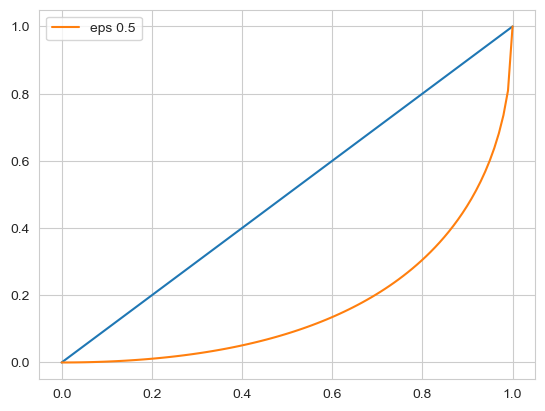

In [9]:
import numpy as np

EPS = 0.5


def scale(x, p=EPS):
    y_p = 1 - np.power(1 - x, p)
    return np.power(y_p, 1 / p)

x = np.linspace(0, 1, 100)
y = x

eps = 0.5
sns.lineplot(x=x, y=x)
sns.lineplot(x=x, y=scale(x, p=eps), label=f'eps {eps}');

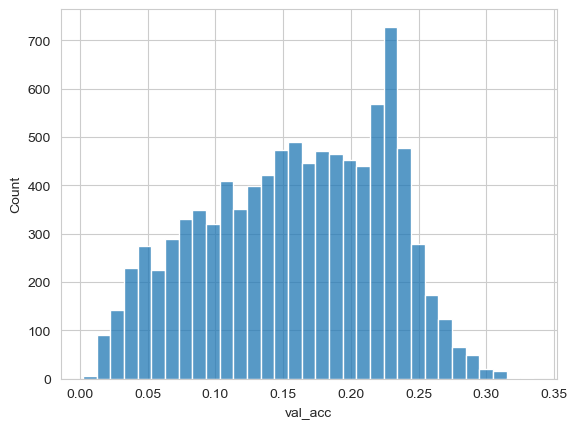

In [14]:
sns.histplot(df.val_acc.apply(scale));

In [12]:
from sophius.encode import Encoder, str_to_vec

encoder = Encoder()

df['vec'] = df['hash'].apply(str_to_vec)
df['seq_len'] = df.vec.apply(len)

C:\Users\alexander.korolyov\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


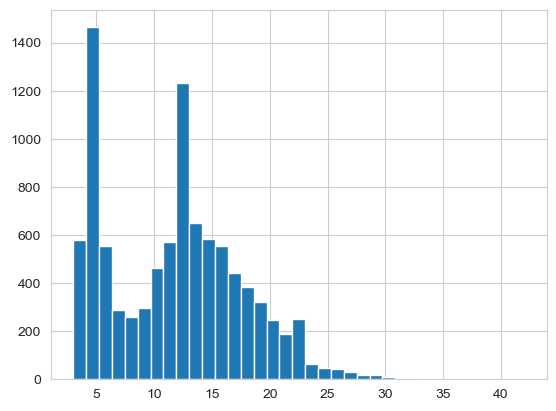

In [13]:
df.seq_len.hist(bins=35);

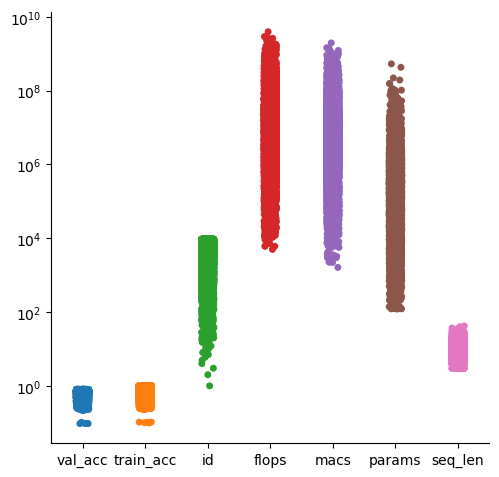

In [10]:
import matplotlib.pyplot as plt
sns.catplot(df);
plt.yscale('log')

In [11]:
# df.query('seq_len > 8').seq_len.hist(bins=25)

In [12]:
# df = df.query('seq_len > 8')
# df = df.query('val_acc >')

In [13]:
import torch
from torch.utils.data import random_split
from sophius.dataload import SequenceLoader, SequenceDataset

RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)

dataset = SequenceDataset(df.vec.tolist(), df.val_acc.values)
train, val = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(RANDOM_SEED))

In [20]:
import pytorch_lightning as pl
import torch
from torch.nn import functional as F

class LSTMLightning(pl.LightningModule):
    def __init__(self,
                 input_dim=32,
                 hidden_dim=128,
                 num_layers=1,
                 dropout=0.0,
                 lr=1e-3,
                 gamma=0.9,
                 eps=None,
                 **_):
        super().__init__()
        self.save_hyperparameters()  # Save hyperparameters
        self.lstm = torch.nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, 1)
        self.lr = lr
        self.gamma = gamma
        self.val_loss = None
        self.eps = eps

    def scale(self, x):
        y_pow = 1 - torch.pow(1 - x, self.eps)
        return torch.pow(y_pow, 1 / self.eps)

    def forward(self, x):
        """Forward pass through the LSTM and linear layers."""
        
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])            
        return out

    def training_step(self, batch, batch_idx):
        sequences, targets = batch
        outputs = self(sequences)
        targets = targets.view(-1, 1)
        if self.eps is not None:
            targets = self.scale(targets)
            outputs = self.scale(outputs)
        loss = F.mse_loss(outputs, targets)
        # self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=False)
        # self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # def validation_step(self, batch, batch_idx):
    #     sequences, targets = batch
    #     outputs = self(sequences)
    #     targets = targets.view(-1, 1)
    #     loss = F.mse_loss(outputs, targets)
    #     self.log('val_loss', loss, on_step=True, on_epoch=False, prog_bar=False)
    #     self.val_loss.append(loss)
    #     return loss
    # 
    # def on_validation_epoch_start(self) -> None:
    #     self.val_loss = []
    # 
    # def on_validation_epoch_end(self):
    #     avg_val_loss = torch.mean(torch.stack(self.val_loss))
    #     # print('val', avg_val_loss, len(self.val_loss))
    #     self.log('hp_metric', avg_val_loss)

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return {
            'optimizer': opt,
            'lr_scheduler': torch.optim.lr_scheduler.ExponentialLR(opt, gamma=self.gamma)
        }

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def plot_results(model, dataset):
    # plt.figure(figsize=(6, 6))
    # plt.gca().set_aspect('equal', adjustable='box')
    res = pd.DataFrame(columns=['y_pred', 'y_true'])
    model.eval()
    model = model.cuda()
    
    with torch.no_grad():
        for seq, y_true in dataset:
            y_pred = model(seq.unsqueeze(0)).item()
            y_true = y_true.item()
            res.loc[len(res)] = [y_pred, y_true]
    print(f'MSE: {mean_squared_error(res.y_true, res.y_pred):.4f}')
    print(f'R^2: {r2_score(res.y_true, res.y_pred):.4f}')
    sns.regplot(res, x='y_pred', y='y_true', scatter_kws={'alpha': 0.1, 's': 5}, line_kws={'linewidth': 1, 'color': 'red', 'alpha': 0.5})#.set_aspect('equal', adjustable='datalim')

## Train lightning model

In [57]:
import warnings
from tqdm import tqdm
from pytorch_lightning.callbacks import TQDMProgressBar

# disable validation bar, buggy in pycharm
class CustomProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        return tqdm(disable=True)

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

hparams = {
    'eps': 0.9,
    'lr': 1e-3,    
    'gamma': 1,
    'hidden_dim': 32,
    'num_layers': 2,
    'dropout': 0.5,
    'input_dim': 32,
    'num_epochs': 5,
    'batch_size': 8,
}

# train_loader = DataLoader(train, batch_size=1, shuffle=False, num_workers=0)
# val_loader = DataLoader(val, batch_size=1, shuffle=False, num_workers=0)
# train_loader = SimpleLoader(train)
# val_loader = SimpleLoader(val)
train_loader = SequenceLoader(train, batch_size=hparams['batch_size'])
val_loader = SequenceLoader(val, batch_size=hparams['batch_size'])

# Initialize model
model = LSTMLightning(**hparams)

# Create PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=hparams['num_epochs'], 
    accelerator='gpu', 
    # log_every_n_steps=4,
    callbacks=[CustomProgressBar()],
)

# Train the model
model.train()
# print(model.device)
trainer.fit(model, train_loader, val_loader)

Epoch 2:  76%|███████▌  | 911/1196 [03:02<00:57,  4.99it/s, loss=0.00196, v_num=32] 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 16.9 K
1 | fc   | Linear | 33    
--------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)



Epoch 4: 100%|██████████| 1196/1196 [00:11<00:00, 102.65it/s, loss=0.00221, v_num=34]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1196/1196 [00:11<00:00, 102.53it/s, loss=0.00221, v_num=34]


MSE: 0.0026
R^2: 0.8213


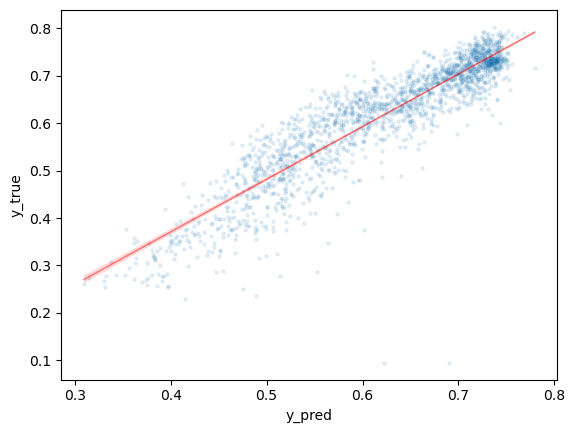

In [43]:
# eps 0.5
plot_results(model, val);

MSE: 0.0021
R^2: 0.8557


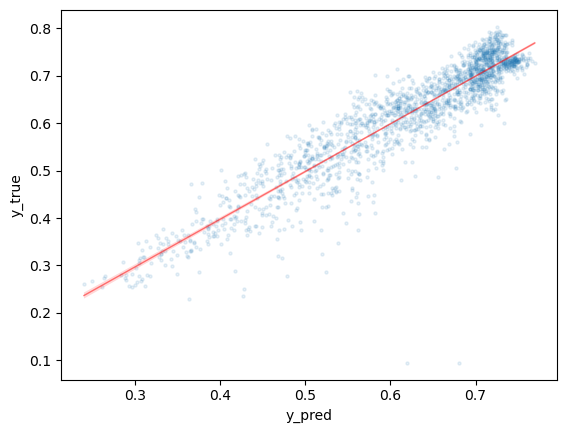

In [39]:
# eps 0.6
plot_results(model, val);

In [52]:
# eps 0.7
plot_results(model, val);

ValueError: Input contains NaN.

MSE: 0.0022
R^2: 0.8501


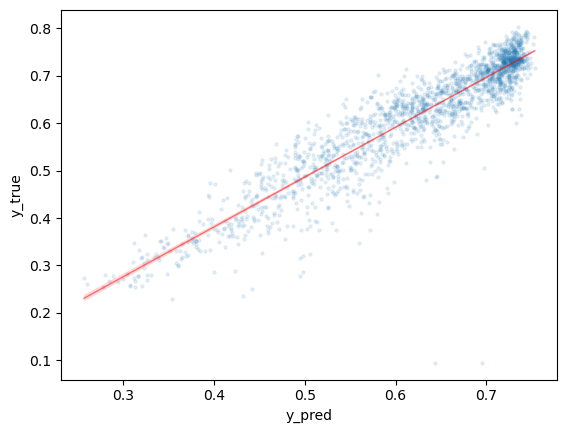

In [58]:
# eps 0.9
plot_results(model, val);

MSE: 0.0026
R^2: 0.8251


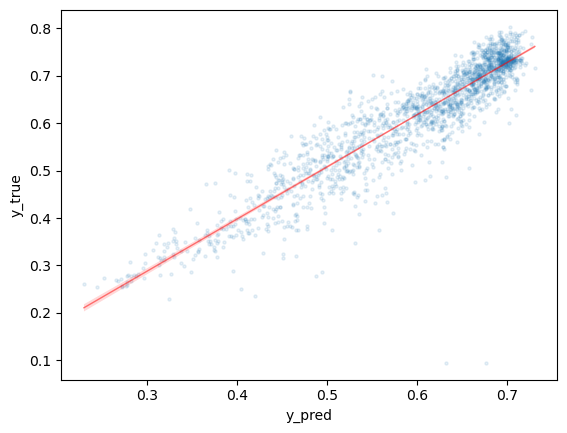

In [56]:
# eps 1.0
plot_results(model, val);

## Train torch model

In [42]:
from sophius.estimate import LSTMRegressor

hparams = {
    'eps': None,
    'lr': 1e-3,    
    'gamma': 1,
    'hidden_dim': 32,
    'num_layers': 2,
    'dropout': 0.5,
    'input_dim': 32,
    'num_epochs': 20,
    'batch_size': 8,
}

reg = LSTMRegressor(**hparams).cuda()

opt = torch.optim.Adam(reg.parameters(), lr=hparams['lr'])
sch = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=hparams['gamma'])
loader = SequenceLoader(dataset, batch_size=hparams['batch_size'])

def scale(x, eps=hparams['eps']):
    return -torch.log10(1 + eps - x)

reg.train()
for i in tqdm(range(hparams['num_epochs']), desc='Epoch'):
    for (x, y) in loader:
        y_pred = reg(x)
        if hparams['eps'] is not None:
            y_pred, y = scale(y_pred), scale(y)
        loss = F.mse_loss(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        sch.step()
        
torch.save(reg, '../data/models/estimator_v3.pth')

Epoch: 100%|██████████| 20/20 [01:41<00:00,  5.10s/it]
